# NMO correction of gradient data

## Author: M.Ravasi

This notebook shows how to perform NMO correction on the gradient data $p_x(t, x)$ following equation 6 in *Robertsson et al., 2008, On the use of multicomponent streamer recordings for reconstruction of pressure wavefields in the crossline direction. Geophysics*.

More precisely, assuming access to both the pressure wavefield $p(t, x)$ and its spatial gradient $p_x(t, x)$, NMO correction must be performed using the following formula:

$$
p_x(t_0, x) = p_x(t(t_0, x), x) + p_t(t(t_0, x), x) * dt/dx
$$

which is the sum of the moveout-corrected pressure gradient, and the
product of the moveout-corrected time derivative of the pressure and
the spatial derivative of the moveout function.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pylops

from scipy import signal, ndimage
from pylops.basicoperators import *
from pylops.utils.wavelets import ricker

from mcslopes.nmoinv import NMO
from mcslopes.preprocessing import butter_lowpass_filter, gradient_data, gradient_nmo_data
from mcslopes.slopes import analytic_local_slope
from mcslopes.plotting import plotting_style

plotting_style()

## 2D

### Load data

Let's start by loading the GOM dataset and filter it to remove aliasing.

In [2]:
# Load data
fload = np.load('../../data/gom_data_forsub5.npz')
x = fload['x']
t = fload['t']
data = fload['data']
dt = t[1] - t[0]
dx = x[1] - x[0]
nt, nx = data.shape

# Filter to remove alias
p = butter_lowpass_filter(data.T, 35., 1/dt, 11)

# Remove direct
p[:, :430] = 0.

### Gradient data

Let's now compute the gradient data in the FK domain

In [3]:
nfft_t, nfft_x = 2**11, 2**9
px, d2, sc1, sc2, Fop, D1op, D2op, D, D1, D2, ks, f = gradient_data(p, nfft_x, nfft_t, dx, dt)

### Gradient of NMO corrected data

We then proceed with computing our benchmark wavefield: the is obtained by first applying NMO correction to the pressure data and then computing the spatial derivative. Of course this is not possible in practice since we will have the gradient data in the original domain.

In [4]:
vnmo = 1500.
NMOOp = NMO(t, x, vnmo * np.ones(nt))

pnmo = NMOOp @ p

Pnmo = Fop * pnmo
Pnmo_grad = (D1op * Pnmo.ravel()).reshape(nfft_x, nfft_t)
pnmo_grad = np.real(Fop.H * Pnmo_grad)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### NMO correction of gradient data

Now we apply the formula presented above to obtain the same results (i.e., gradient of NMO corrected data), however in this case we show that this can be achieved by just using the pressure and gradient data that we can physically record.

In [5]:
pnmo_grad1, pxnmo, ptnmo, dt_dx = gradient_nmo_data(p, px, t, x, vnmo)

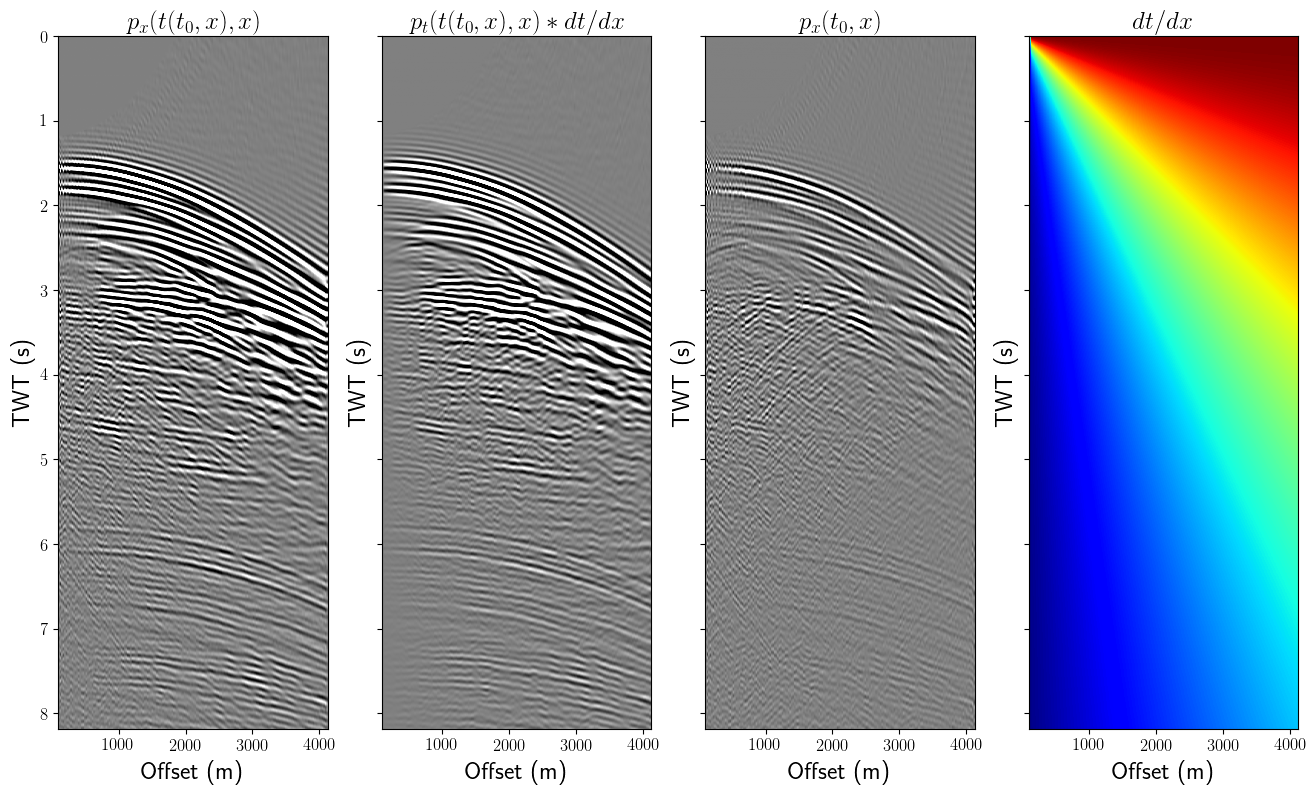

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(16, 9), sharey=True)
axs[0].imshow(np.real(pxnmo.T)[300:1200], cmap='gray', vmin=-0.05, vmax=0.05, extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_xlabel('Offset (m)')
axs[0].set_ylabel('TWT (s)')
axs[0].set_title(r'$p_x(t(t_0, x), x)$')
axs[0].axis('tight')

axs[1].imshow(np.real(ptnmo.T * dt_dx)[300:1200], cmap='gray', vmin=-0.05, vmax=0.05, extent=(x[0], x[-1], t[-1], t[0]))
axs[1].set_xlabel('Offset (m)')
axs[1].set_ylabel('TWT (s)')
axs[1].set_title(r'$p_t(t(t_0, x), x) * dt/dx$')
axs[1].axis('tight')

axs[2].imshow(pnmo_grad1.T[300:1200], cmap='gray', vmin=-0.05, vmax=0.05, extent=(x[0], x[-1], t[-1], t[0]))
axs[2].set_xlabel('Offset (m)')
axs[2].set_ylabel('TWT (s)')
axs[2].set_title(r'$p_x(t_0, x)$')
axs[2].axis('tight')

axs[3].imshow(dt_dx, cmap='jet', extent=(x[0], x[-1], t[-1], t[0]))
axs[3].set_xlabel('Offset (m)')
axs[3].set_ylabel('TWT (s)')
axs[3].set_title(f'$dt/dx$')
axs[3].axis('tight');

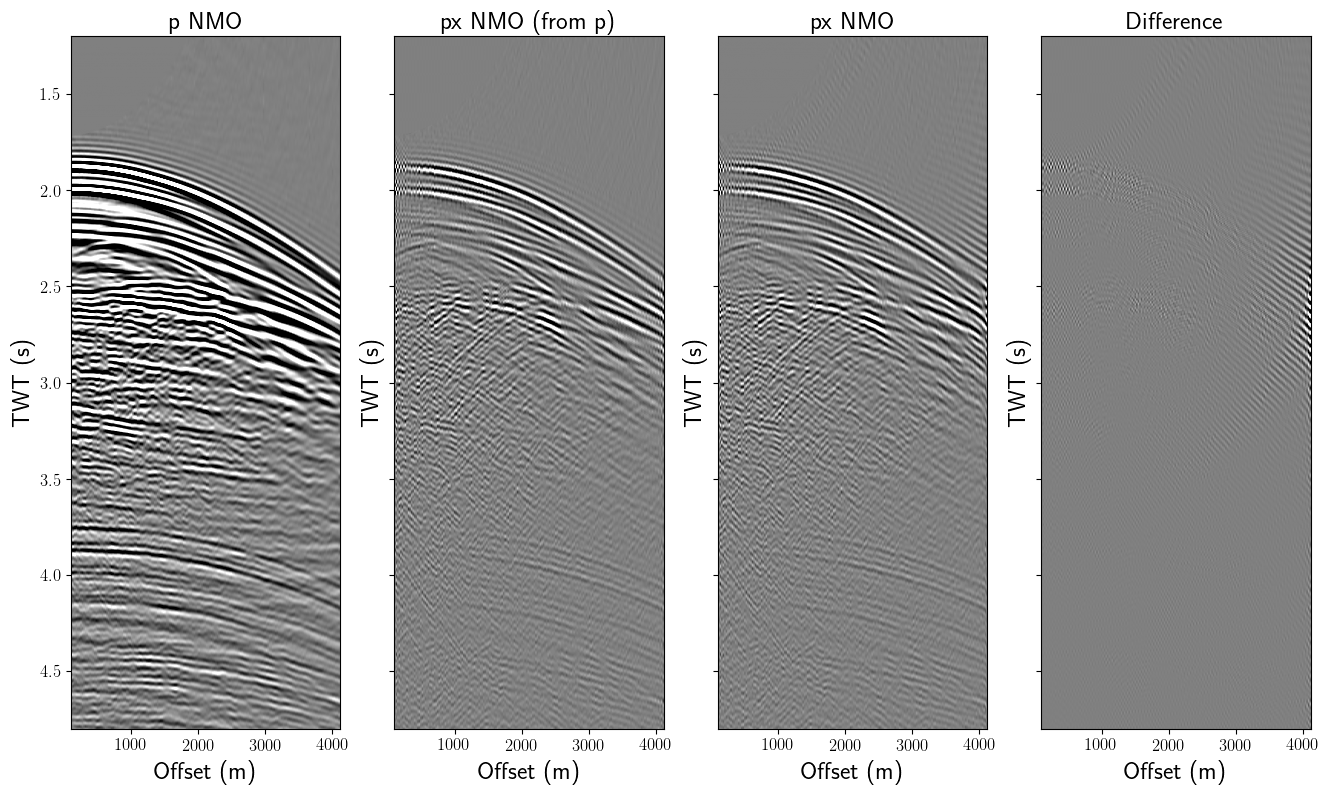

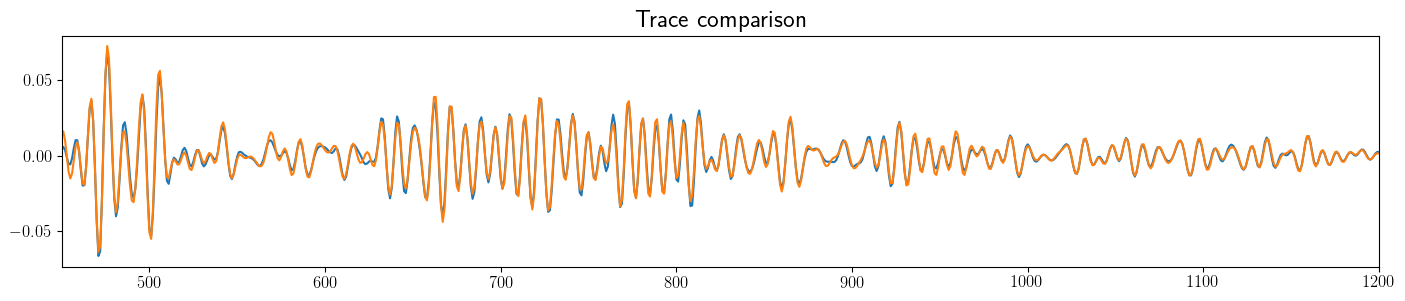

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(16, 9), sharey=True)
axs[0].imshow(pnmo.T[300:1200], cmap='gray', vmin=-1, vmax=1, extent=(x[0], x[-1], t[1200], t[300]))
axs[0].set_xlabel('Offset (m)')
axs[0].set_ylabel('TWT (s)')
axs[0].set_title('p NMO')
axs[0].axis('tight')

axs[1].imshow(pnmo_grad.T[300:1200], cmap='gray', vmin=-0.05, vmax=0.05, extent=(x[0], x[-1], t[1200], t[300]))
axs[1].set_xlabel('Offset (m)')
axs[1].set_ylabel('TWT (s)')
axs[1].set_title('px NMO (from p)')
axs[1].axis('tight')

axs[2].imshow(pnmo_grad1.T[300:1200], cmap='gray', vmin=-0.05, vmax=0.05, extent=(x[0], x[-1], t[1200], t[300]))
axs[2].set_xlabel('Offset (m)')
axs[2].set_ylabel('TWT (s)')
axs[2].set_title('px NMO')
axs[2].axis('tight')

axs[3].imshow((pnmo_grad.T-pnmo_grad1.T)[300:1200], cmap='gray', vmin=-0.05, vmax=0.05,
              extent=(x[0], x[-1], t[1200], t[300]))
axs[3].set_xlabel('Offset (m)')
axs[3].set_ylabel('TWT (s)')
axs[3].set_title('Difference')
axs[3].axis('tight')

plt.figure(figsize=(17, 3))
plt.plot(pnmo_grad[30])
plt.plot(pnmo_grad1[30])
plt.xlim(450, 1200)
plt.title('Trace comparison');